In [71]:
import numpy as onp
import matplotlib.pyplot as plt

import jax 
from jax import config, jit, vmap, grad 
config.update("jax_enable_x64", True)
import jax.numpy as np
import jax.scipy as jsp
import jax.random as jr

import pyoifits as oifits
import glob

from drpangloss.models import *
from drpangloss.plotting import *
from drpangloss.grid_fit import *
from drpangloss.savefits import GetWavelength, save

import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig

In [72]:
ls ../data/jwst

bls.npy                 err_HD-37093_F380M.npy  vis_HD-36805_F380M.npy
err_AB-DOR_F380M.npy    err_HD-37093_F430M.npy  vis_HD-36805_F430M.npy
err_AB-DOR_F430M.npy    err_HD-37093_F480M.npy  vis_HD-36805_F480M.npy
err_AB-DOR_F480M.npy    inds.npy                vis_HD-37093_F380M.npy
err_HD-36805_F380M.npy  vis_AB-DOR_F380M.npy    vis_HD-37093_F430M.npy
err_HD-36805_F430M.npy  vis_AB-DOR_F430M.npy    vis_HD-37093_F480M.npy
err_HD-36805_F480M.npy  vis_AB-DOR_F480M.npy


/Users/benpope/opt/anaconda3/envs/pangloss/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [73]:
ddir = '../data/jwst/'
filter = 'F480M'
fnames_vis = glob.glob(ddir+f'vis_*{filter}.npy')
fnames_err = glob.glob(ddir+f'err_*{filter}.npy')
bls = np.load(ddir+'bls.npy')
print(fnames_vis)
print(fnames_err)

['../data/jwst/vis_HD-36805_F480M.npy', '../data/jwst/vis_AB-DOR_F480M.npy', '../data/jwst/vis_HD-37093_F480M.npy']
['../data/jwst/err_AB-DOR_F480M.npy', '../data/jwst/err_HD-37093_F480M.npy', '../data/jwst/err_HD-36805_F480M.npy']


In [74]:
# identify the files
abdor = onp.array(['AB-DOR' in fname for fname in fnames_vis])
cals = ~abdor

# load AB Dor visibilities
vis_abdor = np.load(fnames_vis[onp.where(abdor)[0][0]])
err_abdor = np.load(fnames_err[onp.where(abdor)[0][0]])

# load calibrator visibilities
vis_cal1, vis_cal2 = np.load(fnames_vis[onp.where(cals)[0][0]]), np.load(fnames_vis[onp.where(cals)[0][1]])
err_cal1, err_cal2 = np.load(fnames_err[onp.where(cals)[0][0]]), np.load(fnames_err[onp.where(cals)[0][1]]) # TODO: fix how errors are saved

# turn the complex numbers into amplitudes and phases
rad2deg = 180/np.pi
v2_abdor, phase_abdor = np.abs(vis_abdor)**2, np.angle(vis_abdor)*rad2deg
v2_cal1, v2_cal2 = np.abs(vis_cal1)**2, np.abs(vis_cal2)**2
phase_cal1, phase_cal2 = np.angle(vis_cal1)*rad2deg, np.angle(vis_cal2)*rad2deg

# and for uncertainties
v2_abdor_err, phase_abdor_err = 2*np.abs(err_abdor), np.angle(err_abdor)*rad2deg # this is deeply sinful
v2_cal1_err, v2_cal2_err = 2*np.abs(err_cal1), 2*np.abs(err_cal2)
phase_cal1_err, phase_cal2_err = np.angle(err_cal1)*rad2deg, np.angle(err_cal2)*rad2deg # this is deeply sinful 

# get baseline lengths
bl = (bls**2).sum(axis=1)**0.5


In [75]:
## verify that the error propagation by taylor series is correct (it is)

# draws_real, draws_imag = 1+err_cal1.real * onp.random.randn(21,1000).T, err_cal1.imag * onp.random.randn(21,1000).T
# error_vis = np.std(np.abs(draws_real + 1.j*draws_imag)**2, axis=0)
# error_phase = np.std(np.angle(draws_real + 1.j*draws_imag), axis=0)

# print((error_phase*180/np.pi)/phase_cal1_err)
# print((error_vis)/v2_cal1_err)

Text(0.5, 0.98, 'Uncalibrated AMI Data: F480M')

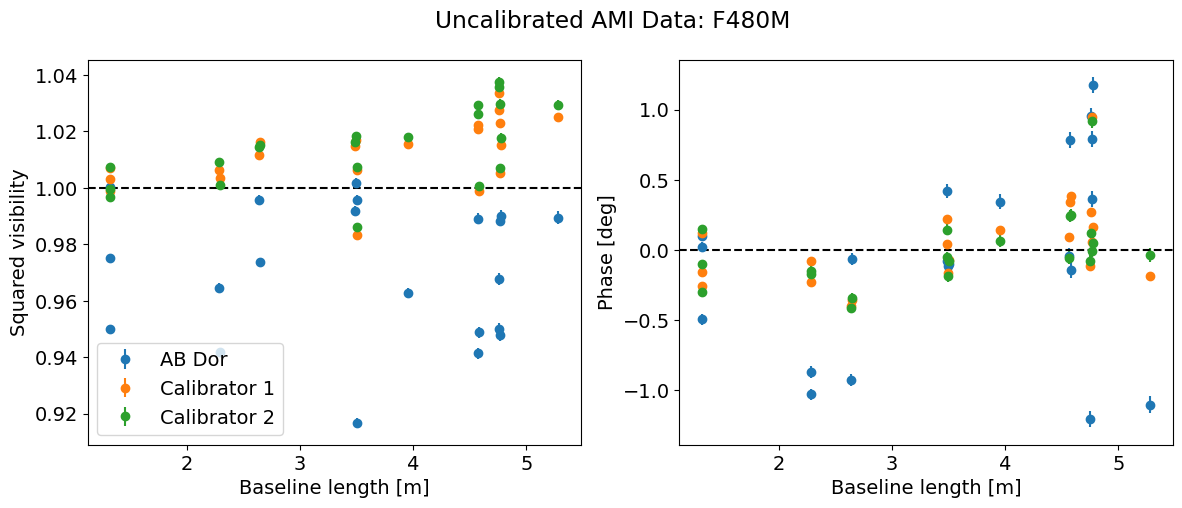

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.errorbar(bl, v2_abdor, yerr=v2_abdor_err, fmt='o', label='AB Dor')
ax1.errorbar(bl, v2_cal1, yerr=v2_cal1_err, fmt='o', label='Calibrator 1')
ax1.errorbar(bl, v2_cal2, yerr=v2_cal2_err, fmt='o', label='Calibrator 2')
ax1.axhline(1, color='k', ls='--')

ax1.set_xlabel('Baseline length [m]')
ax1.set_ylabel('Squared visibility')
ax1.legend()

ax2.errorbar(bl, phase_abdor, yerr=phase_abdor_err, fmt='o', label='AB Dor')
ax2.errorbar(bl, phase_cal1, yerr=phase_cal1_err, fmt='o', label='Calibrator 1')
ax2.errorbar(bl, phase_cal2, yerr=phase_cal2_err, fmt='o', label='Calibrator 2')
ax2.axhline(0, color='k', ls='--')
ax2.set_xlabel('Baseline length [m]')
ax2.set_ylabel('Phase [deg]')

plt.suptitle(f'Uncalibrated AMI Data: {filter}')

Text(0.5, 0.98, 'Calibrated AMI Data: F480M')

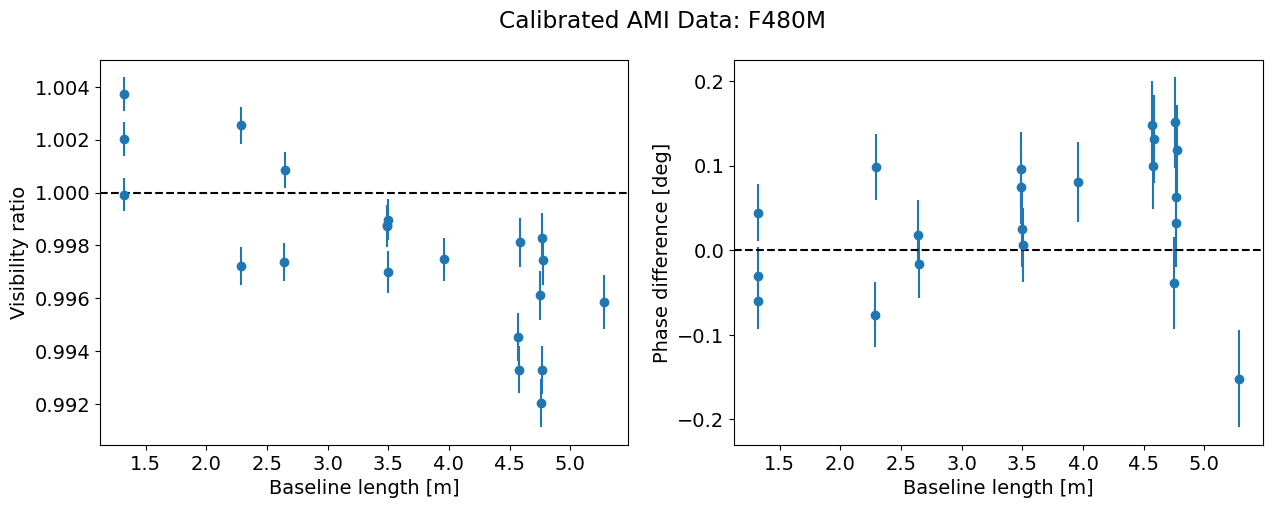

In [77]:
# visualize how well the calibrators calibrate each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.errorbar(bl, v2_cal1/v2_cal2, yerr=v2_cal1_err/v2_cal2, fmt='o', label='Calibrator 1 / Calibrator 2')
ax1.axhline(1, color='k', ls='--')
ax1.set_xlabel('Baseline length [m]')
ax1.set_ylabel('Visibility ratio')

ax2.errorbar(bl, phase_cal1-phase_cal2, yerr=(phase_cal1_err**2+phase_cal2_err**2)**0.5, fmt='o', label='Calibrator 1 - Calibrator 2')
ax2.axhline(0, color='k', ls='--')
ax2.set_xlabel('Baseline length [m]')
ax2.set_ylabel('Phase difference [deg]')

plt.suptitle(f'Calibrated AMI Data: {filter}')

In [78]:
# dict for OIData

abdor_dict = {
        'u': bls[:,0],
        'v': bls[:,1],
        'wavel': GetWavelength('JWST',filter)[0],
        'vis': v2_abdor,
        'd_vis': v2_abdor_err,
        'phi': phase_abdor,
        'd_phi': phase_abdor_err,
        'i_cps1': None,
        'i_cps2': None,
        'i_cps3': None,
        'v2_flag': True,
        'cp_flag': False
        }

oidata_abdor = OIData(abdor_dict)

cal1_dict = {
        'u': bls[:,0],
        'v': bls[:,1],
        'wavel': GetWavelength('JWST',filter)[0],
        'vis': v2_cal1,
        'd_vis': v2_cal1_err,
        'phi': phase_cal1,
        'd_phi': phase_cal1_err,
        'i_cps1': None,
        'i_cps2': None,
        'i_cps3': None,
        'v2_flag': True,
        'cp_flag': False
        }

cal2_dict = {
        'u': bls[:,0],
        'v': bls[:,1],
        'wavel': GetWavelength('JWST',filter)[0],
        'vis': v2_cal2,
        'd_vis': v2_cal2_err,
        'phi': phase_cal2,
        'd_phi': phase_cal2_err,
        'i_cps1': None,
        'i_cps2': None,
        'i_cps3': None,
        'v2_flag': True,
        'cp_flag': False
        }

oidata_cal1 = OIData(cal1_dict)
oidata_cal2 = OIData(cal2_dict)

/Users/benpope/opt/anaconda3/envs/pangloss/lib/python3.11/site-packages/drpangloss/models.py:181: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.i_cps1 = np.array(data['i_cps1'],dtype=int)


In [79]:
# calibrate the calibrators
v2_cal1_cal2 = v2_cal1/v2_cal2
phase_cal1_cal2 = phase_cal1 - phase_cal2

# propagate the errors
v2_cal1_cal2_err = v2_cal1_cal2 * (v2_cal1_err/v2_cal1 + v2_cal2_err/v2_cal2)
phase_cal1_cal2_err = (phase_cal1_err**2 + phase_cal2_err**2)**0.5

# make a dict and turn it into an OIData object

cal1_cal2_oidata = OIData({
        'u': bls[:,0],
        'v': bls[:,1],
        'wavel': GetWavelength('JWST',filter)[0],
        'vis': v2_cal1_cal2,
        'd_vis': v2_cal1_cal2_err,
        'phi': phase_cal1_cal2,
        'd_phi': phase_cal1_cal2_err,
        'i_cps1': None,
        'i_cps2': None,
        'i_cps3': None,
        'v2_flag': True,
        'cp_flag': False
        })

# calibrate AB Dor with the mean of the two calibrators
v2cal_abdor = v2_abdor/(0.5*(v2_cal1+v2_cal2))
phase_cal_abdor = phase_abdor - 0.5*(phase_cal1+phase_cal2)

# propagate the errors
v2cal_abdor_err = v2cal_abdor * (v2_abdor_err/v2_abdor + 0.5*(v2_cal1_err/v2_cal1+v2_cal2_err/v2_cal2))
phase_cal_abdor_err = (phase_cal1_err**2 + phase_cal2_err**2)**0.5

# oidata object for calibrated AB Dor

cal_abdor_oidata = OIData({
        'u': bls[:,0],
        'v': bls[:,1],
        'wavel': GetWavelength('JWST',filter)[0],
        'vis': v2cal_abdor,
        'd_vis': v2cal_abdor_err,
        'phi': phase_cal_abdor/rad2deg,
        'd_phi': phase_cal_abdor_err/rad2deg,
        'i_cps1': None,
        'i_cps2': None,
        'i_cps3': None,
        'v2_flag': True,
        'cp_flag': False
        })

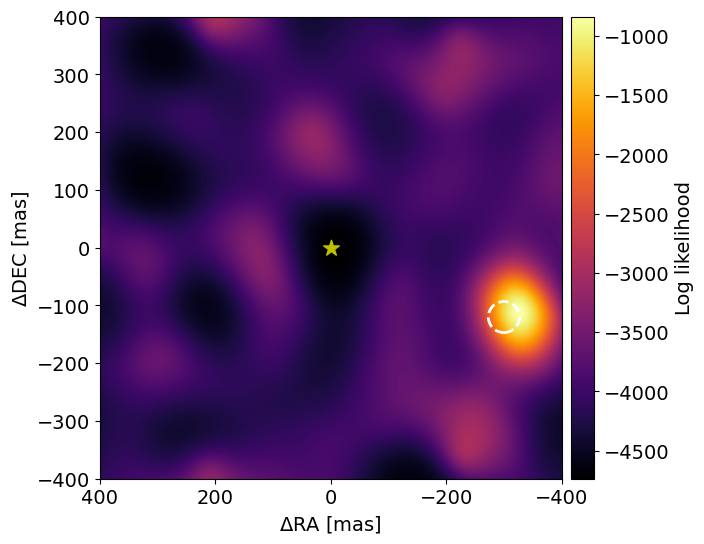

In [80]:
params = ["dra", "ddec", "flux"]

samples_dict = {
    "dra":  np.linspace(400., -400., 200), # left is more RA 
    "ddec": np.linspace(-400., 400., 210), # up is more dec
    "flux": 10**np.linspace(-6, 0, 220)
    }

loglike_im = likelihood_grid(cal_abdor_oidata, BinaryModelCartesian, samples_dict) # calculate once to jit
plot_likelihood_grid(loglike_im.max(axis=2), samples_dict,truths=(-300,-120))


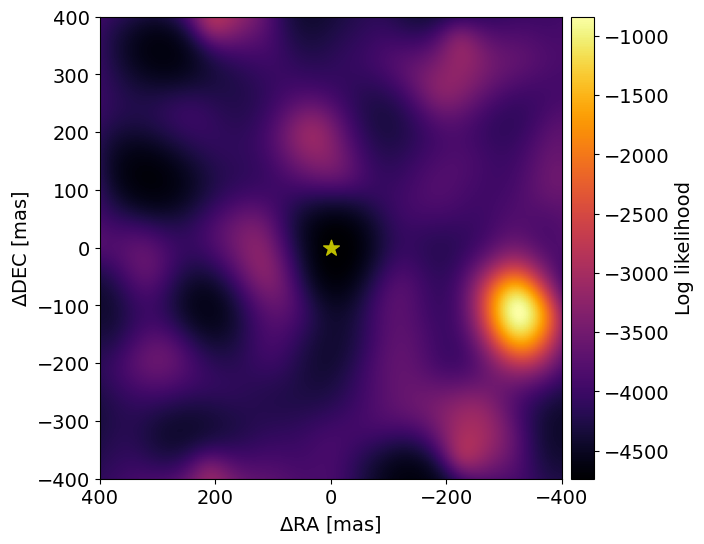

In [81]:
optimized_like_im = optimized_likelihood_grid(cal_abdor_oidata, BinaryModelCartesian, samples_dict)
plot_likelihood_grid(optimized_like_im, samples_dict)

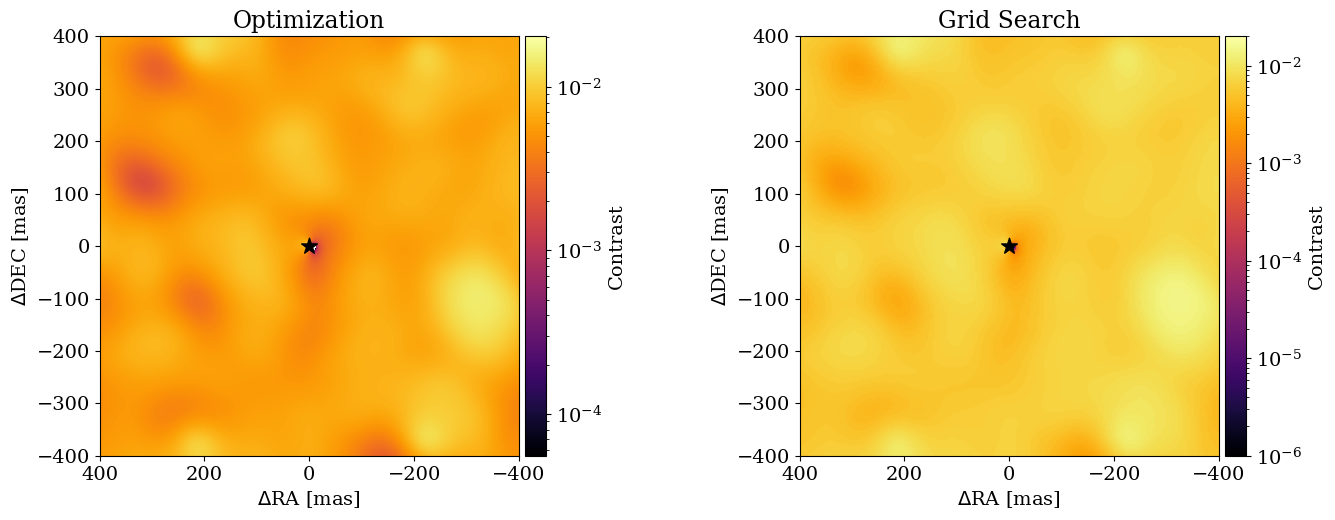

In [82]:
best_contrast_indices = np.argmax(loglike_im,axis=2)
best_contrasts = samples_dict['flux'][best_contrast_indices]

optimized = optimized_contrast_grid(cal_abdor_oidata, BinaryModelCartesian, samples_dict)

plot_optimized_and_grid(loglike_im, optimized, samples_dict) 

Something nasty is going on here - I think it's finding the complementary *negative* flux best fit because the binary signal is so strong. We should fix the code to enforce positive flux everywhere. 

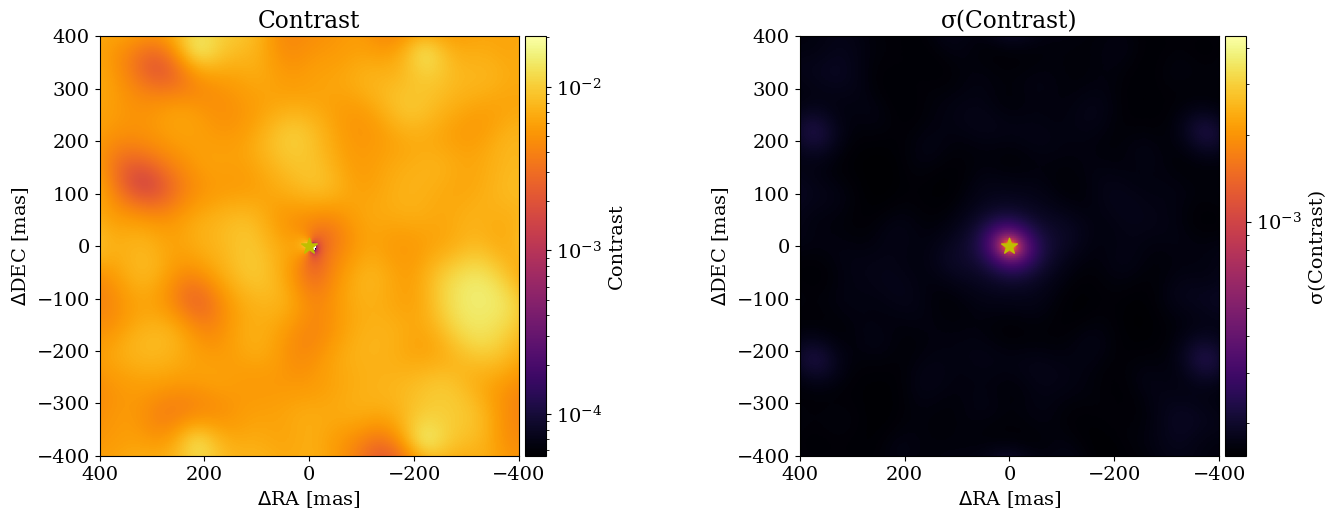

In [83]:
laplace_sigma_grid = laplace_contrast_uncertainty_grid(best_contrast_indices, cal_abdor_oidata, BinaryModelCartesian, samples_dict)
plot_optimized_and_sigma(optimized, laplace_sigma_grid, samples_dict,snr=False)

In [84]:
def sampling_fn(data_obj, model_class):

    # Define priors
    dra, ddec, log_flux = [npy.sample("Δ RA",    dist.Uniform(-350, -250)), 
              npy.sample("Δ Dec",   dist.Uniform(-150, -100)),
              npy.sample("log Flux",    dist.Uniform(-3,0))
            ] 
    # TODO: how do we set appropriate priors in Cartesian coordinates? 
    # TODO: it would be good for this to be defined by the model_class itself
    flux = npy.deterministic("flux", 10**log_flux) # so that we save this
    dmag = npy.deterministic("Δ Mag", -2.5*np.log10(flux)) # so that we save this
    sep = npy.deterministic("Sep", (dra**2 + ddec**2)**0.5)
    pa = npy.deterministic("PA", np.arctan2(ddec, dra)*180/np.pi)

    # predict the data 
    pred_data = npy.deterministic("pred", data_obj.model(model_class(dra,ddec,flux)))
    errorscale = npy.sample("jitter", dist.Uniform(0.0,2.0))

    data, errors = data_obj.flatten_data()
    # Sample from the posterior distribution
    model_sampler = dist.Normal(pred_data,errors*10**errorscale)
    return npy.sample("Sampler", model_sampler, obs=data)


In [85]:
# Using the model above, we can now sample from the posterior distribution
# using the No U-Turn Sampler (NUTS).
sampler = npy.infer.MCMC(
    npy.infer.NUTS(sampling_fn),
    num_warmup=5000,
    num_samples=10000,
)
sampler.run(jr.PRNGKey(0), cal_abdor_oidata, BinaryModelCartesian)

posterior_pred = sampler.get_samples()['pred']
print('Error scaling:',10**sampler.get_samples()['jitter'].mean())

sample: 100%|██████████| 15000/15000 [00:02<00:00, 5224.85it/s, 7 steps of size 6.52e-01. acc. prob=0.90]


Error scaling: 6.628914976465925


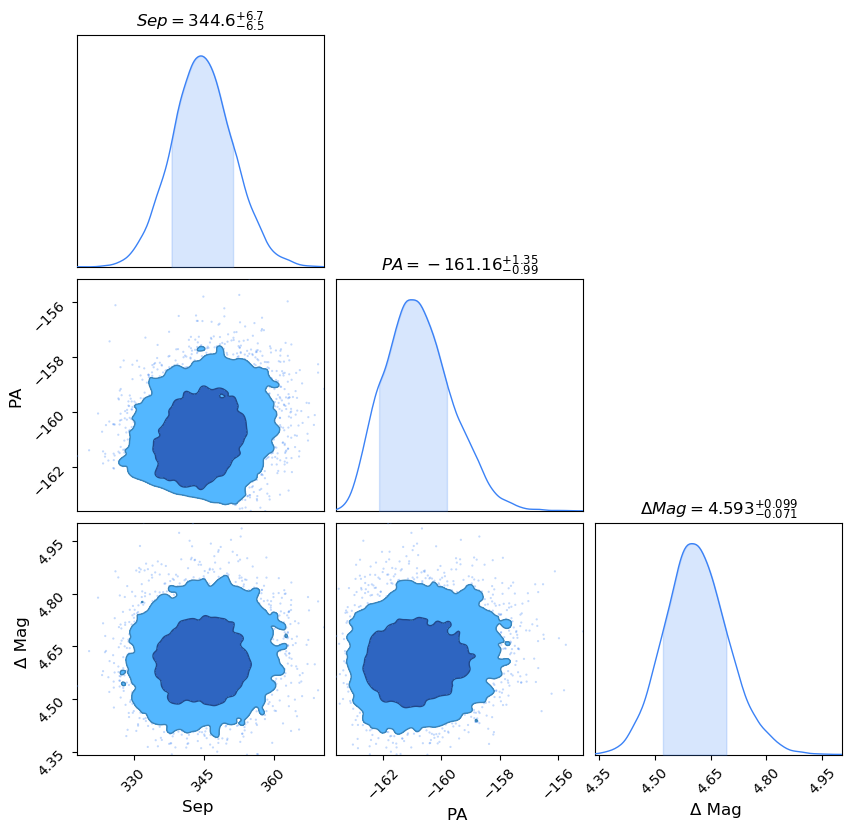

In [86]:
results = sampler.get_samples()
results = {key:results[key] for key in ["Sep", "PA", "Δ Mag"]}
cc_df = pd.DataFrame.from_dict(results)

c = ChainConsumer()  

c.add_chain(Chain(samples=cc_df,name="MCMC Results",
                                    plot_point=True,
                                    plot_cloud=True,
                                    marker_style="*",
                                    marker_size=100,
                                ))
# truths = {key:val for key, val in zip(results.keys(), [np.log10(5e-4), 150., 150.])} # TODO: the ordering should be fixed
# c.add_truth(Truth(location=truths))
c.plotter.plot();
  


Text(0.5, 1.0, 'Phases')

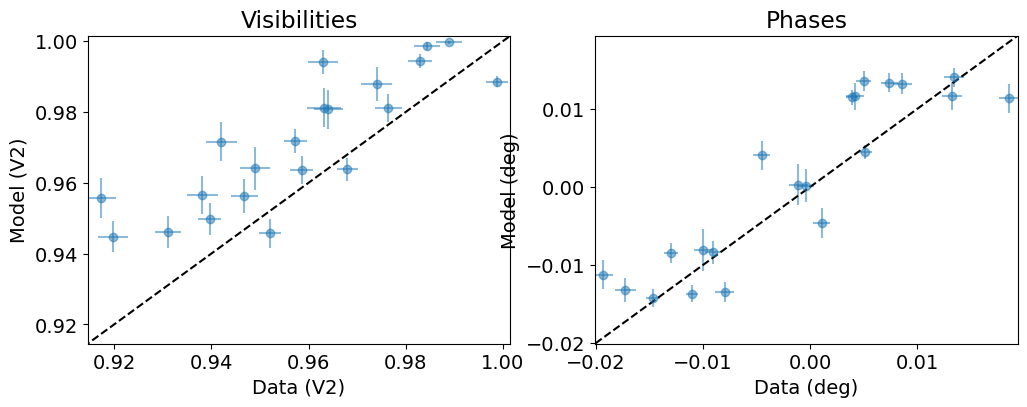

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

posterior_mean = np.mean(posterior_pred, axis=0)
posterior_std = np.std(posterior_pred, axis=0)

# plot data 
ax1.errorbar(cal_abdor_oidata.vis, posterior_mean[:len(cal_abdor_oidata.vis)], 
             xerr=cal_abdor_oidata.d_vis, yerr = posterior_std[:len(cal_abdor_oidata.vis)],
             fmt='o', alpha=0.5,color='C0')

ax2.errorbar(cal_abdor_oidata.phi, posterior_mean[len(cal_abdor_oidata.vis):], 
             xerr=cal_abdor_oidata.d_phi, yerr = posterior_std[len(cal_abdor_oidata.vis):],
             fmt='o', alpha=0.5,color='C0')

vis_121 = np.linspace(cal_abdor_oidata.vis.min()-np.median(cal_abdor_oidata.d_vis)*2, cal_abdor_oidata.vis.max()+np.median(cal_abdor_oidata.d_vis)*2, 100)
phi_121 = np.linspace(cal_abdor_oidata.phi.min()-np.median(cal_abdor_oidata.d_phi)*2, cal_abdor_oidata.phi.max()+np.median(cal_abdor_oidata.d_phi)*2, 100)

# plot 1:1 lines
ax1.plot(vis_121, vis_121, 'k--')
ax1.set_xlim(cal_abdor_oidata.vis.min()-np.median(cal_abdor_oidata.d_vis), cal_abdor_oidata.vis.max()+np.median(cal_abdor_oidata.d_vis))
ax1.set_ylim(cal_abdor_oidata.vis.min()-np.median(cal_abdor_oidata.d_vis), cal_abdor_oidata.vis.max()+np.median(cal_abdor_oidata.d_vis))

ax2.plot(phi_121, phi_121, 'k--')
ax2.set_xlim(cal_abdor_oidata.phi.min()-np.median(cal_abdor_oidata.d_phi), cal_abdor_oidata.phi.max()+np.median(cal_abdor_oidata.d_phi))
ax2.set_ylim(cal_abdor_oidata.phi.min()-np.median(cal_abdor_oidata.d_phi), cal_abdor_oidata.phi.max()+np.median(cal_abdor_oidata.d_phi))

# plot labels 
ax1.set_xlabel('Data (V2)')
ax1.set_ylabel('Model (V2)')
ax1.set_title('Visibilities')

ax2.set_xlabel('Data (deg)')
ax2.set_ylabel('Model (deg)')
ax2.set_title('Phases')

Still not super happy with this corner plot - the phases and uncertainties are clearly wrong, but this is probably just from how we are propagating the errors from amigo.